## Задание
 Построение модели линейной регрессии, настройка гиперпараметров на кросс-валидации, интерпретация коэффициентов.

## Цель: 
В этом дз вы потренируетесь строить интерпретируемые модели линейной регрессии с регуляризацией и без. Снова пройдемся по основным этапам работы с данными и на выходе получим модели, способные предсказывать цены на жильё в AirBnb.
Снова предсказание цены квартиры, но на сей раз съемной :)

1. Скачайте данные с Kaggle по ценам на жильё в Airbnb в Нью-Йорке:
https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data

2. Пройдите по основным шагам работы с данными - базовые статистики, визуализации (распределения, корреляции, pair plots), предобработка переменных.

`Переменные, которые пока нужно убрать: id, name, host_id, host_name, last_review.`

Обратите внимание на распределение целевой переменной.

Во время предобработки не забудьте закодировать категориальные переменные (one-hot encoding, можно использовать pd.get_dummies) и прошкалировать непрерывные.

Бонусное задание по предобработке - найдите координаты центра Нью-Йорка и при помощи евклидового расстояния создайте новую переменную "center_distance" используя широту и долготу центра и текущей квартиры. Этот признак для линейной регрессии будет работать гораздо лучше, чем просто широта и долгота, так что их можно будет спокойно убрать из датасета.

3. Отложите 30% данных для тестирования и постройте модели простой линейной регрессии, RidgeCV, LassoCV и ElasticNetCV. Измерьте качество каждой и визуализируйте важность признаков. Сделайте интересные выводы :) 

In [2]:
import pandas as pd               # уже знакомый вам пакет для работы с таблицами
import numpy as np                # смутно знакомый вам пакет для работы с матрицами
import matplotlib.pyplot as plt   # уже знакомый вам пакет для картинок 
import matplotlib as mplt
import seaborn as sns             # ещё один пакет для картинок 
import math

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

# EDA

Загрузим датасет и посмотрим на данные

In [3]:
df = pd.read_csv('data/AB_NYC_2019.csv')  # подгружаем табличку 
print('Размер выборки:', df.shape)                          # смотрим на её размеры 
df.head( ) # Смотрим что лежит в табличке 

Размер выборки: (48895, 16)


,id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
0,2539,Clean & quiet apt home by the park,2787,John,Brooklyn,Kensington,40.64749,-73.97237,Private room,149,1,9,2018-10-19,0.21,6,365
1,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
2,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
3,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
4,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0


В соответствии с заданием удаляем признаки:
`id, name, host_id, host_name, last_review`.

In [4]:
df.drop(columns=['id', 'name', 'host_id', 'host_name', 'last_review'], inplace=True)

## 1. Анализ целевой переменной

Целевой переменной является `price` - цена аренды за сутки. Выведем ее гистограмму.

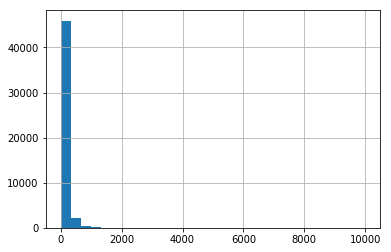

In [5]:
df['price'].hist(bins=30)

Из графика видно, что переменная имеет длинный "хвост" и принимает `нулевые!` значения.

Посмотрим на выбросы в данных.

In [6]:
df[['price']].describe(percentiles=[.25, .5, .75, .95, .99])

,price
count,48895.000000
mean,152.720687
std,240.154170
min,0.000000
25%,69.000000
50%,106.000000
75%,175.000000
95%,355.000000
99%,799.000000
max,10000.000000


Сравнение значения `95%, 99%` перцентиля с `max` занчением показывает, что цена за сутки `95%` квартир не превышает `$355`, для `99%` не превышает `$799`, а максимальная цена составляет `$10000`. Таким образом удалять данные не стоит.

Удалим данные, в которых значение признака `price` равно 0 и и проведем логарифмирование.

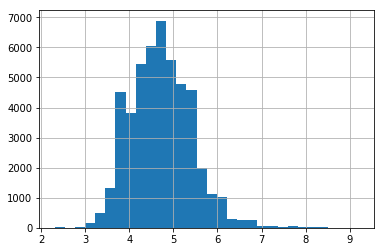

In [7]:
df.drop(index=df[df['price'] == 0].index, inplace=True)
df['price'] = np.log(df['price'])
df['price'].hist(bins=30)

## 2. Анализ признаков

Проверим данные на пропуски:

In [8]:
df.info(verbose=True);

reviews_per_month_len = len(df[~df['reviews_per_month'].isna()])
df_len = len(df)

print("\nДанных в `reviews_per_month` меньше на {}% относительно остальных признаков.".format(
    round(100 - 100 * reviews_per_month_len / df_len))
     )

print('\nПосмотрим, сколько в данных NaN значений:\n')
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48884 entries, 0 to 48894
Data columns (total 11 columns):
neighbourhood_group               48884 non-null object
neighbourhood                     48884 non-null object
latitude                          48884 non-null float64
longitude                         48884 non-null float64
room_type                         48884 non-null object
price                             48884 non-null float64
minimum_nights                    48884 non-null int64
number_of_reviews                 48884 non-null int64
reviews_per_month                 38833 non-null float64
calculated_host_listings_count    48884 non-null int64
availability_365                  48884 non-null int64
dtypes: float64(4), int64(4), object(3)
memory usage: 4.5+ MB

Данных в `reviews_per_month` меньше на 21% относительно остальных признаков.

Посмотрим, сколько в данных NaN значений:

neighbourhood_group                   0
neighbourhood                         0
latitude   

Отсутствие 21% данных не является критичным. Также не обходимо заполнить пропуски в признаке `reviews_per_month`.

Посчитаем количество признаков по типам:

In [9]:
df.columns.to_series().groupby([df.dtypes,df.columns]).count()

int64    availability_365                  1
         calculated_host_listings_count    1
         minimum_nights                    1
         number_of_reviews                 1
float64  latitude                          1
         longitude                         1
         price                             1
         reviews_per_month                 1
object   neighbourhood                     1
         neighbourhood_group               1
         room_type                         1
dtype: int64

Из 11 признаков, только 3 категориальные: `neighbourhood, neighbourhood_group, room_type`.
Рассмотрим их.

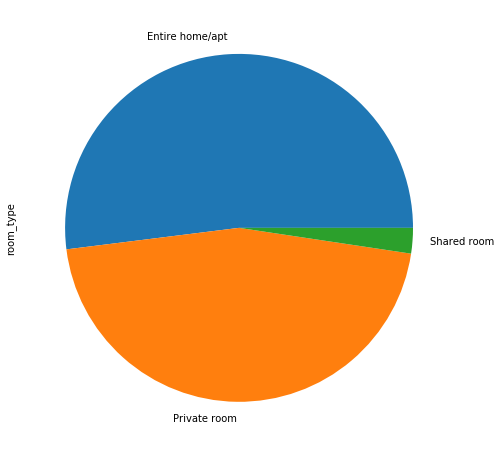

In [10]:
df['room_type'].value_counts().plot(kind='pie', figsize=(8, 8))

Видно, что есть преобладание признаков `private room`,`entire home/apt` над `shared room`.

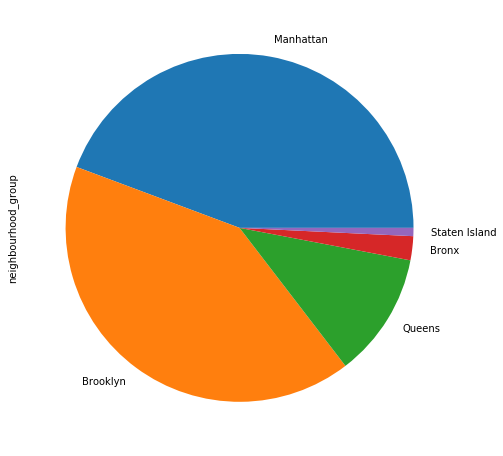

In [11]:
df['neighbourhood_group'].value_counts().plot(kind='pie', figsize=(8, 8))

Болшье всего жилья сдается в боро `Brooklyn` и `Manhattan`.

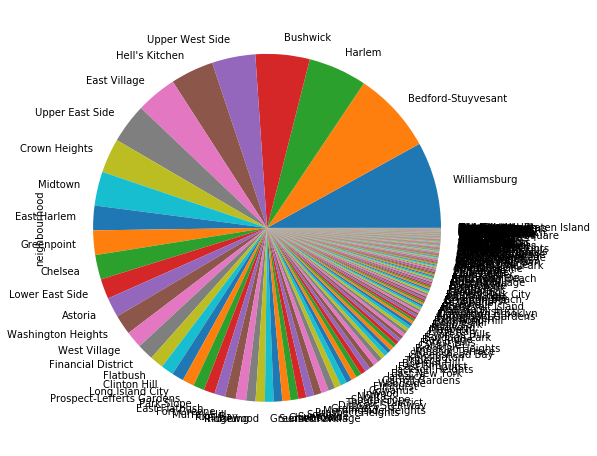

In [12]:
df['neighbourhood'].value_counts().plot(kind='pie', figsize=(8, 8))

Не очень удачная визуализация, но наглядно отображает распределение районов. Районы входят в состав боро, таким образом можно сделать вывод, что вклад данных по районам включен в данные боро. И эти признаки можно либо удалить либо кластеризовать.

Посмотрим выбросы в данных.

In [13]:
df.drop('price',axis=1).describe(percentiles=[.25, .5, .75, .95, .99])

,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,48884.000000,48884.000000,48884.000000,48884.000000,38833.000000,48884.000000,48884.000000
mean,40.728953,-73.952176,7.029887,23.271991,1.373128,7.144628,112.779498
std,0.054532,0.046159,20.512224,44.551331,1.680391,32.956185,131.627271
min,40.499790,-74.244420,1.000000,0.000000,0.010000,1.000000,0.000000
25%,40.690100,-73.983080,1.000000,1.000000,0.190000,1.000000,0.000000
50%,40.723080,-73.955685,3.000000,5.000000,0.720000,1.000000,45.000000
75%,40.763120,-73.936290,5.000000,24.000000,2.020000,2.000000,227.000000
95%,40.825638,-73.865755,30.000000,114.000000,4.640000,15.000000,359.000000
99%,40.864662,-73.776903,45.000000,214.000000,7.196800,232.000000,365.000000
max,40.913060,-73.712990,1250.000000,629.000000,58.500000,327.000000,365.000000


Признаки `minimum_nights, reviews_per_month` имеют явные выбросы, так как `99%` данных имеют значением на порядки меньше максимального значения.

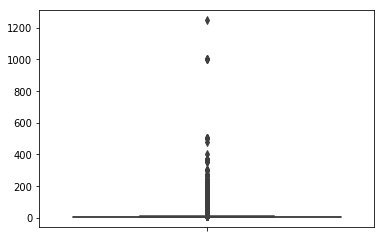

In [14]:
sns.boxplot(y=["minimum_nights"], data=df)

Посмотрим сколько данных у признака `minimum_nights` больше `600`.

In [15]:
df[df['minimum_nights'] > 600]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
2854,Manhattan,Battery Park City,40.71239,-74.01620,Entire home/apt,5.991465,1000,0,NaN,1,362
5767,Manhattan,Greenwich Village,40.73293,-73.99782,Entire home/apt,5.192957,1250,2,0.03,1,365
13404,Manhattan,Harlem,40.82915,-73.94034,Entire home/apt,4.595120,999,2,0.07,1,42
26341,Brooklyn,Williamsburg,40.71772,-73.95059,Private room,4.369448,999,24,1.12,6,249
38664,Manhattan,Greenwich Village,40.73094,-73.99900,Shared room,4.700480,999,0,NaN,1,365


Удалим их из выборки.

In [16]:
df.drop(index=df[df['minimum_nights'] > 600].index, inplace=True)

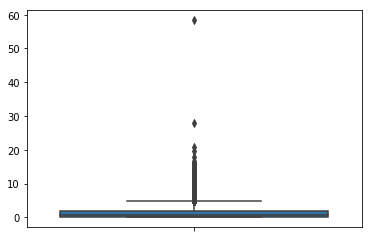

In [17]:
sns.boxplot(y=["reviews_per_month"], data=df)

Посмотрим сколько данных у признака reviews_per_month больше 35.

In [18]:
df[df['reviews_per_month'] > 35]

,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
42075,Manhattan,Theater District,40.75918,-73.98801,Private room,4.60517,1,156,58.5,9,299


Удалим значение из выборки.

In [19]:
df.drop(index=df[df['reviews_per_month'] > 35].index, inplace=True)

Построим диаграммы распределений.

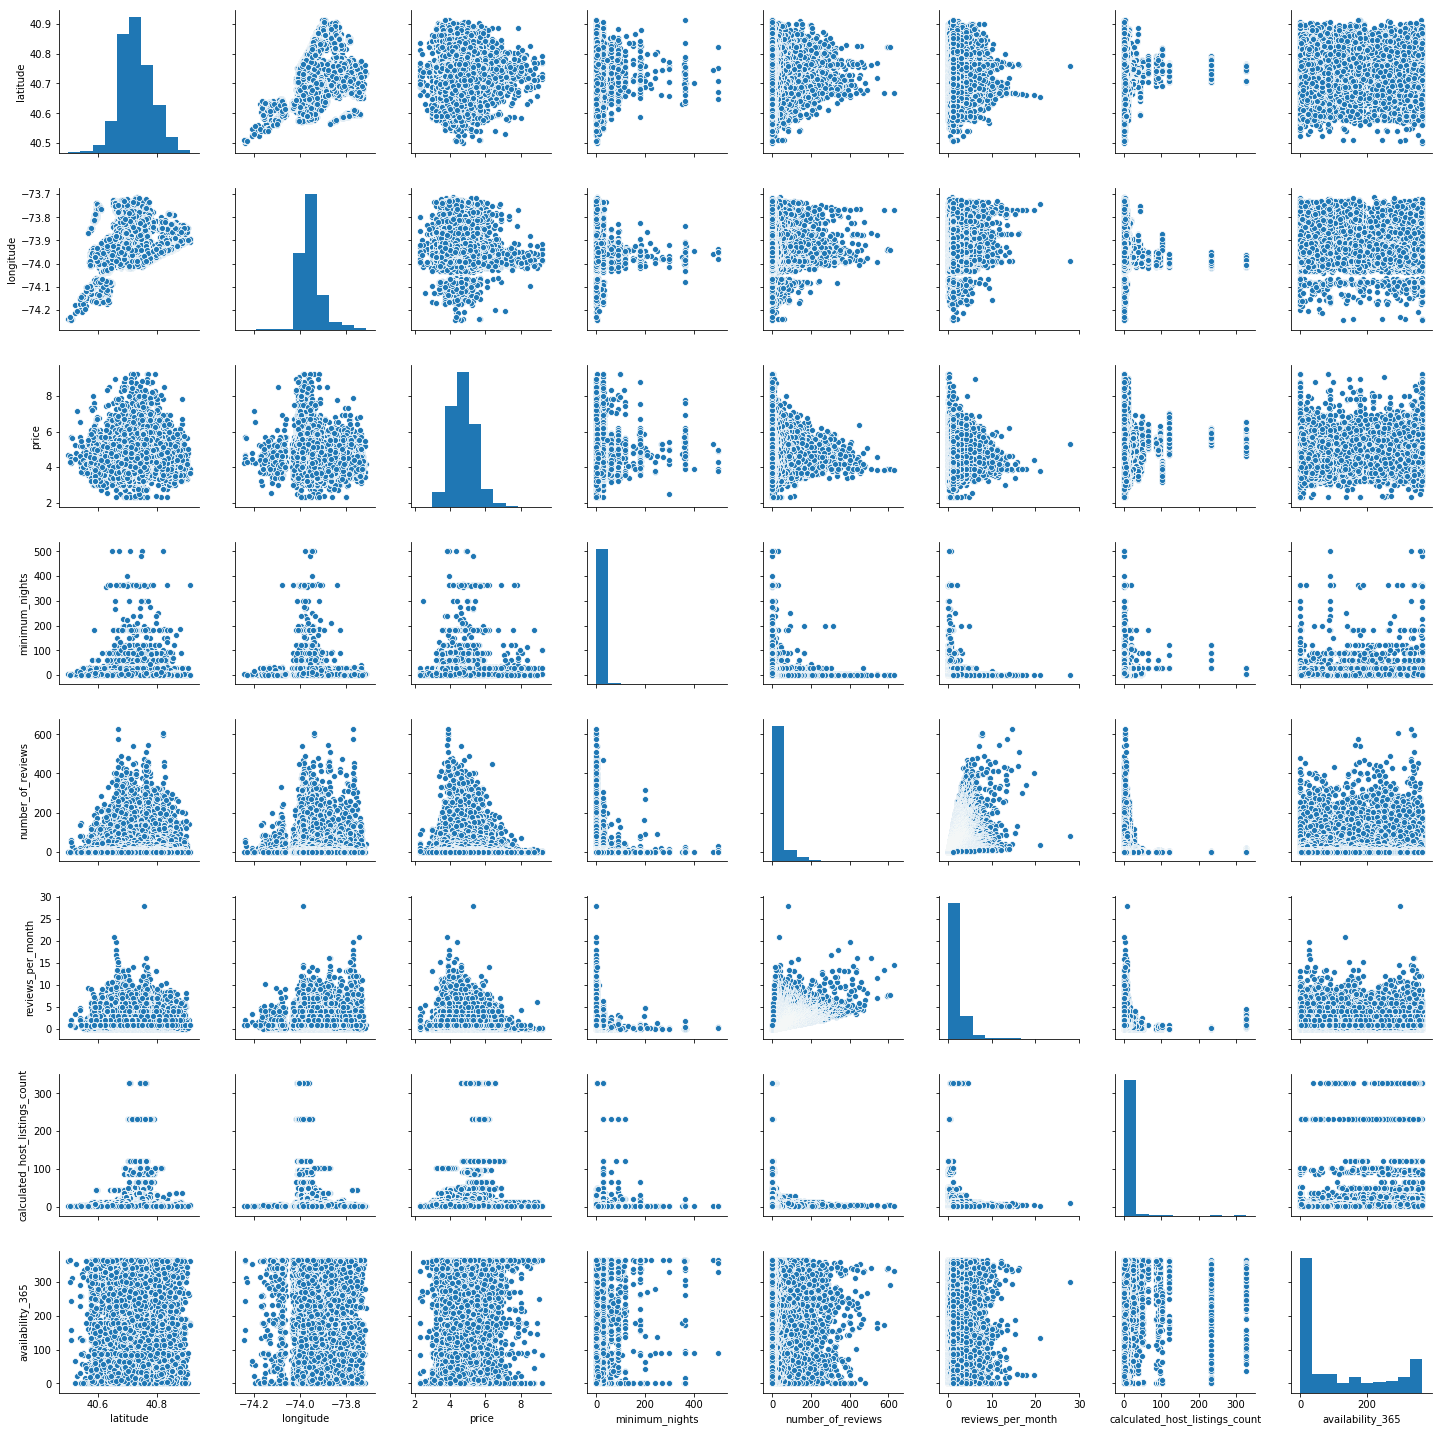

In [20]:
sns.pairplot(df)

Из диаграмм видно, что `price` не имеет линейной зависимости от `latitude,longitude`. Но видна зависимость `reviews_per_month` от `number_of_reviews`.

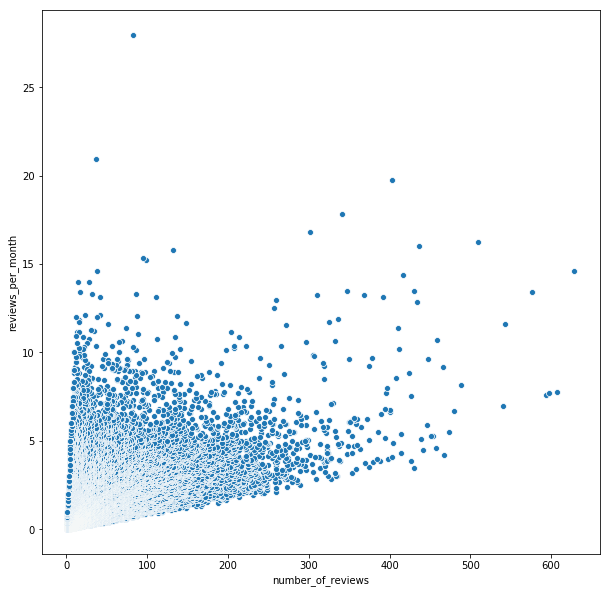

In [21]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.scatterplot(x=df['number_of_reviews'],y=df['reviews_per_month'], ax=ax)

Посмотрим корреляцию признаков.

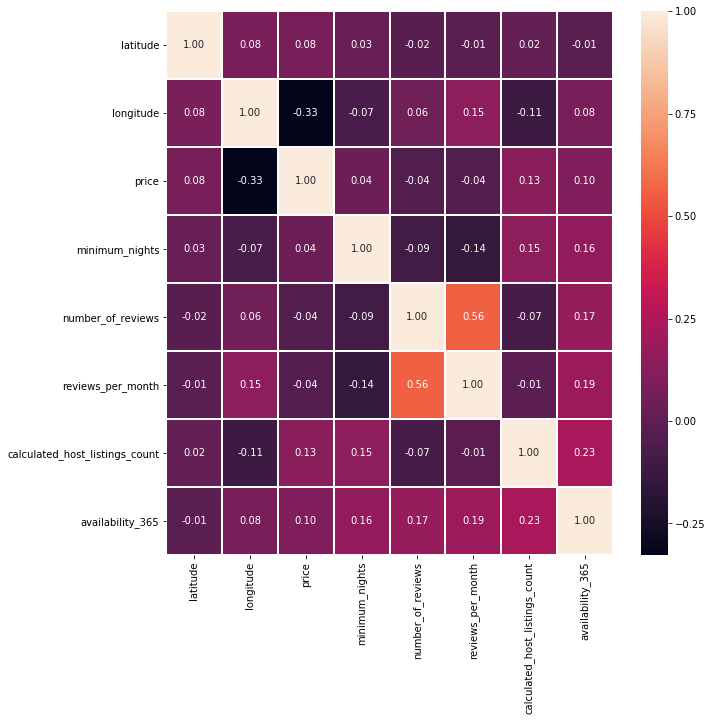

In [22]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df.corr(), annot=True, linewidths=1, fmt='.2f',ax=ax)

Явной корреляции не наблюдается.

Построим гистограммы.

In [ ]:
df.drop('price',axis=1).hist(figsize=(20, 12));

Распределение близкое к нормальному имеют только признаки `latitude,longitude`, что очевидно.

## 3. Обработка пропущенных данных

Необходимо заполнить пропуски данных для признака `reviews_per_month`.

In [ ]:
df_reviews = df[[
    'latitude', 'longitude', 'price', 'minimum_nights', 
    'number_of_reviews', 'reviews_per_month', 
    'calculated_host_listings_count', 'availability_365'
]].copy()
df_reviews[:5]

In [ ]:
df_reviews['reviews_per_month'] = np.where(df_reviews['number_of_reviews']!=0, df_reviews['reviews_per_month'],.0)

In [ ]:
from sklearn.linear_model import LinearRegression

y_train = df_reviews['reviews_per_month']
X_train = df_reviews.drop('reviews_per_month', axis = 1)
print(X_train.shape)
model_regression = LinearRegression()
model_regression.fit(X_train, y_train)

df_reviews['reviews_per_month_pred'] = model_regression.predict(df_reviews.drop('reviews_per_month', axis = 1))
df['reviews_per_month'] = np.where(~df_reviews['reviews_per_month'].isnull(),df_reviews['reviews_per_month'],df_reviews['reviews_per_month_pred'])
del df_reviews

In [ ]:
df.info()

Теперь наши данные не содержат пропусков.

## 4. Подготовка датасета

Исходя из предположения выше о важности признака `neighbourhood` и что его данные уже содержаться в `neighbourhood_group` - удали этот признак. Остальные категориальные признаки преобразуем с помошью `get_dummies`.

In [ ]:
df.drop(['neighbourhood'], inplace=True, axis=1)

df_dumm = pd.get_dummies(df[['neighbourhood_group','room_type']])

df = pd.concat([df.drop(['neighbourhood_group','room_type'],axis=1),df_dumm], axis=1)
df.head()

Определим центр масс координат с помощью нахождения медианы. Созданим новый признак `center_distance` и включим его в выборку. Признаки `latitude, longitude` искллючим из выборки.

In [ ]:
center_phi,center_lambda = df['latitude'].median(), df['longitude'].median()
print('Координаты центра:',center_phi,center_lambda)

from sklearn.metrics.pairwise import euclidean_distances
df['center_distance'] = euclidean_distances(df[['latitude','longitude']],[[center_phi,center_lambda]])
df.drop(columns=['latitude','longitude'], inplace=True)
df.head()

Разделим нашу выборку на тренировочную и проверочную и производем шкалирование.

In [ ]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size = 0.3)

In [ ]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

scaler = StandardScaler()

scaler.fit(df_train[[
    'minimum_nights','number_of_reviews','reviews_per_month',
    'calculated_host_listings_count','availability_365','center_distance'
]]) 

In [ ]:
df_train_scale = scaler.transform(
    df_train[[
        'minimum_nights','number_of_reviews','reviews_per_month',
        'calculated_host_listings_count','availability_365','center_distance'
    ]]
)

df_test_scale = scaler.transform(
    df_test[[
        'minimum_nights','number_of_reviews','reviews_per_month',
        'calculated_host_listings_count','availability_365','center_distance'
    ]]
)

In [ ]:
df_train[[
    'minimum_nights','number_of_reviews','reviews_per_month',
    'calculated_host_listings_count','availability_365','center_distance'
]] = df_train_scale

df_test[[
    'minimum_nights','number_of_reviews','reviews_per_month',
    'calculated_host_listings_count','availability_365','center_distance'
]] = df_test_scale

In [ ]:
print(df_train.shape) # Посмотрим на размеры трэйна и теста 
print(df_test.shape) 

Выделим целевую переменную и признаки.

In [ ]:
y_train = df_train.price 
y_test = df_test.price 

X_train = df_train.drop('price', axis=1).get_values()
X_test = df_test.drop('price', axis=1).get_values()

## 5. Базовая модель

Создадим базовую модель на основе среднего значения целевой переменной.

In [ ]:
y_mean = np.mean(y_train)
y_pred_naive = np.ones(len(y_test)) * y_mean  
y_pred_naive[:5]

## 6. Метрики качества

In [ ]:
from sklearn import metrics 

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def print_metrics(y_test,y_pred,values=False):
    mae = metrics.mean_absolute_error(np.exp(y_test), np.exp(y_pred))
    rmse = np.sqrt(metrics.mean_squared_error(np.exp(y_test), np.exp(y_pred)))
    r2 = metrics.r2_score(y_test, y_pred)
    mape = mean_absolute_percentage_error(y_test, y_pred)
    
    if values:
        return {'MAE':mae, 'RMSE':rmse, 'R2':r2, 'MAPE':mape}
    
    print('MAE:', mae)
    print('RMSE:', rmse)
    print('R2:',  r2)
    print('MAPE:', mape)
    pass
    

print_metrics(y_test, y_pred_naive)

## 4. Построение модели

Добавим функцию построения графика важности признаков.

In [ ]:
def importance_plot(df, model_coef, figsize=(10,6)):
    featureImportance = pd.DataFrame({"feature": df.drop('price',axis=1).columns, 
                                  "importance": model_coef})
    
    featureImportance.set_index('feature', inplace=True)
    featureImportance.sort_values(["importance"], ascending=False, inplace=True)
    featureImportance["importance"].plot('bar', figsize=figsize);

### 4.1 LinearRegression

Построим простую линейную регрессию и выведем график важности признаков.

In [ ]:
from sklearn.linear_model import LinearRegression

model_regression = LinearRegression()

model_regression.fit(X_train, y_train)
y_pred_regr = model_regression.predict(X_test)

In [ ]:
print_metrics(y_test, y_pred_regr)
importance_plot(df, model_regression.coef_);

Видно, что положительно на цену влияют аренда все квартиры и ее расположение в боро Манхеттен, отрицательно влияют совместное проживание и удаленность от центра.

### 4.2 GridSearchCV

Подберем для модели лучшие параметры с помощью `GridSearchCV`.

In [ ]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Решётака для перебора параметра 
param_grid = {'alpha': [0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10]}

# Объявили модель 
model_lasso = Lasso() 

# Объявили перебор 
grid_cv_lasso = GridSearchCV(model_lasso, param_grid, cv = 5)
grid_cv_lasso.fit(X_train, y_train)
print('Лучшее значение параметра:', grid_cv_lasso.best_params_)

# Сделали прогнозы
y_pred_lasso = grid_cv_lasso.predict(X_test)

In [ ]:
print_metrics(y_test, y_pred_lasso)
importance_plot(df, grid_cv_lasso.best_estimator_.coef_)

Главные признаки остались без изменений, а вот отрицательное влияние цену теперь указывают вторичные признаки: проживание в боро Бруклин и Куинс.

### 4.3 RidgeCV

Подберем для модели лучшие параметры с помощью RidgeCV.

In [ ]:
from sklearn.linear_model import RidgeCV, Ridge

model_ridge = Ridge() 

ridge_cv_ridge = RidgeCV(alphas=[0.00001, 0.0001, 0.001, 0.01, 0.05, 0.1, 0.5, 0.8, 1, 5, 10],store_cv_values=True)
ridge_cv_ridge.fit(X_train, y_train)
print('Лучшее значение параметра:', ridge_cv_ridge.cv_values_[0][0])

# # Сделали прогнозы
y_pred_ridge = ridge_cv_ridge.predict(X_test)

In [ ]:
print_metrics(y_test, y_pred_lasso)
importance_plot(df, ridge_cv_ridge.coef_)

Главные признаки `RidgeCV` не изменила, а среди вторичных отрицательных отметила проживание в частной комнате и удаленность от центра.

### 4.4 ElasticNetCV

Подберем для модели лучшие параметры с помощью ElasticNetCV.

In [ ]:
from sklearn.linear_model import ElasticNetCV,ElasticNet

model_elastic = ElasticNet() 

elastic_cv_elastic = ElasticNetCV(cv=5, random_state=42)
elastic_cv_elastic.fit(X_train, y_train)
print('Лучшее значение параметра:', elastic_cv_elastic.alpha_)

# # Сделали прогнозы
y_pred_elastic = elastic_cv_elastic.predict(X_test)

In [ ]:
print_metrics(y_test, y_pred_elastic)
importance_plot(df, elastic_cv_elastic.coef_)

Главные признаки ElasticNetCV сообтветствуют RidgeCV, но в качестве вторичных отрицательных выделено расстояние от центра.

In [ ]:
d_y_pred_naive = print_metrics(y_test,y_pred_naive,values=True)
d_y_pred_naive.update({'Name':'Naive'})

d_y_pred_regr = print_metrics(y_test,y_pred_regr,values=True)
d_y_pred_regr.update({'Name':'Simple Linear'})

d_y_pred_lasso = print_metrics(y_test,y_pred_lasso,values=True)
d_y_pred_lasso.update({'Name':'GridSearchCV'})

d_y_pred_ridge = print_metrics(y_test,y_pred_ridge,values=True)
d_y_pred_ridge.update({'Name':'RidgeCV'})

d_y_pred_elastic = print_metrics(y_test,y_pred_elastic,values=True)
d_y_pred_elastic.update({'Name':'ElasticNetCV'})


df_summary = pd.DataFrame([d_y_pred_naive,d_y_pred_regr,d_y_pred_lasso,d_y_pred_ridge,d_y_pred_elastic])
df_summary.set_index('Name',inplace=True)
df_summary

# Выводы

1. По абсолютной ошибке `MAE` лучший результат у `ElasticNetCV` = `$64.586`
1. По корню из квадратичной ошибки `RMSE` лучший результат у `Simple Linear` = `$248.794`
1. Наиболее лучше обясняет данные `Simple Linear`, где  `R2` = `0.496517`
1. По средней абсолютной ошибке `MAPE`, лучшая модель `Simple Linear` = `7.5618`
1. Главный признак, положительно вляющий на цену - это арнеда полностью всей квартиры `room type` = `rntire home/apt`
1. Главный признак, отрицательно влияющий на цену - это совместная аренда квартиры `room type` = `shared room`
1. Вторично отрицательно на цену влияют: `center distance`, `room type` = `private room`, `neighbourhood group` = `Brooklyn`
1. Вторично положительно на цену влияют: `neighbourhood group` = `Manhattan` и `availability_365`